# Imports

In [6]:
import sys
import time
import errno
import time
import timeit
import pickle
import os
import multiprocessing
import warnings
import yaml
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import numpy as np
import xarray as xr
import scipy as scp
from scipy import signal, interpolate, stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
import arviz as az
from tqdm.notebook import tqdm, trange

import jax 
import jax.numpy as jnp
from jax.lib import xla_bridge
from jax import random
from jax import grad, vmap, lax, random
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cuda")
print(f"number of cores:", jax.local_device_count())
print(f"using: ", xla_bridge.get_backend().platform)
rng_key = random.PRNGKey(0)

from functools import partial
from jax.experimental.ode import odeint
import numba
from numba import jit
import numpyro as npyr
from numpyro import sample, plate
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

number of cores: 1
using:  gpu


In [7]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"npyr version: {npyr.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
Numba version: 0.57.1
JAX version: 0.4.25
npyr version: 0.13.2
SciPy version: 1.9.3
Arviz version: 0.16.1


In [ ]:
parent_preprocess_dir = ''

cwd = os.getcwd()
output_dir= cwd + '/output_numpyro/'
! mkdir -p $output_dir

## Simulator

In [9]:
cpu_device = jax.devices('cpu')[0]
selected_device = cpu_device

jax.config.update('jax_default_device', selected_device)

In [10]:
tend = 100.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]
ns = 9
nt

1001

In [11]:
x_init=np.zeros((ns))

In [12]:
alpha=-0.56
constants=np.array([alpha])

In [13]:
g_1=0.0045
g_2=1.1
g_3=0.1
g_4=0.15

In [15]:
theta_true = np.array([g_1, g_2, g_3, g_4])
n_prms = theta_true.shape[0]
n_prms

4

In [50]:
def erp_default_config(tend=100, dt=0.1, t0=0, ns=9, constants=np.array([-0.56])):

    ts = np.arange(t0, tend + dt, dt)
    nt = ts.shape[0]
    x_init=np.zeros((ns))

    return ts, nt, x_init, constants

def simulate_from_posterior(params, tend=100):

    ts, nt, x_init, constants = erp_default_config(tend=tend)
    
    simData = DCM_NMM_ERP_ODE_JAXOdeint_full(params, constants, x_init, ts)

    xsc = simData[:, 0]
    xin = simData[:, 6]
    xpy = simData[:, 8]
    
    return xsc, xin, xpy

In [ ]:
def DCM_default_params():

    delta=8.41
    tau_i=7.77
    h_i=27.87
    tau_e=5.77
    h_e=1.63
    u=3.94
    
    return delta, tau_i, h_i, tau_e, h_e, u

In [68]:
#####################################################
def LSE(x1, x2):
    return np.sum((x1 - x2)**2)
#####################################################
def Err(x1, x2):
    return np.sum(np.abs(x1 - x2))
#####################################################    
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 
#####################################################
def LSE_obs(Obs, Obs_lo, Obs_hi):
    return np.average([LSE(Obs, Obs_lo), LSE(Obs, Obs_hi)])
#####################################################
def z_score(true_mean, post_mean, post_std):
    return np.abs((post_mean - true_mean) / post_std)
#####################################################
def shrinkage(prior_std, post_std):
    return 1 - (post_std / prior_std)**2
#####################################################

from scipy.stats import gaussian_kde
from sbi.analysis.plot import _get_default_opts, _update, ensure_numpy


def _get_limits(samples, limits=None):

    if type(samples) != list:
        samples = ensure_numpy(samples)
        samples = [samples]
    else:
        for i, sample_pack in enumerate(samples):
            samples[i] = ensure_numpy(samples[i])

    # Dimensionality of the problem.
    dim = samples[0].shape[1]

    if limits == [] or limits is None:
        limits = []
        for d in range(dim):
            min = +np.inf
            max = -np.inf
            for sample in samples:
                min_ = sample[:, d].min()
                min = min_ if min_ < min else min
                max_ = sample[:, d].max()
                max = max_ if max_ > max else max
            limits.append([min, max])
    else:
        if len(limits) == 1:
            limits = [limits[0] for _ in range(dim)]
        else:
            limits = limits
    limits = torch.as_tensor(limits)

    return limits

def posterior_peaks(samples, return_dict=False, **kwargs):
    '''
    Finds the peaks of the posterior distribution.

    Args:
        samples: torch.tensor, samples from posterior
    Returns: torch.tensor, peaks of the posterior distribution
            if labels provided as a list of strings, and return_dict is True
            returns a dictionary of peaks

    '''

    opts = _get_default_opts()
    opts = _update(opts, kwargs)

    if type(samples) != np.ndarray:
        samples = samples.numpy()

    limits = _get_limits(samples)
    n, dim = samples.shape

    try:
        labels = opts['labels']
    except:
        labels = range(dim)

    peaks = {}
    if labels is None:
        labels = range(dim)
    for i in range(dim):
        peaks[labels[i]] = 0

    for row in range(dim):
        density = gaussian_kde(
            samples[:, row],
            bw_method=opts["kde_diag"]["bw_method"])
        xs = np.linspace(
            limits[row, 0], limits[row, 1],
            opts["kde_diag"]["bins"])
        ys = density(xs)

        # y, x = np.histogram(samples[:, row], bins=bins)
        peaks[labels[row]] = xs[ys.argmax()]

    if return_dict:
        return peaks
    else:
        return list(peaks.values())
    
def plot_posterior(samples,
                   ax,
                   prob=[0.025, 0.975],
                   labels=None,
                   xlim=None,
                   ylim=None,
                   xticks=None,
                   yticks=None,
                   xlabel=None,
                   ylabel=None):

    if ax is None:
        print('pass axis!')
        exit(0)

    samples = samples.numpy()
    # print(type(samples))
    # print(samples.shape)
    dim = samples.shape[1]
    # assert (len(ax) == dim)
    if labels is not None:
        assert (len(labels) == dim)

    hist_diag = {"alpha": 1.0, "bins": 50, "density": True, "histtype": "step"}

    max_values = np.zeros(dim)

    for i in range(dim):
        ax0 = ax if (dim == 1) else ax[i]
        n, bins, _ = ax0.hist(samples[:, i], **hist_diag)

        if labels is not None:
            ax0.set_xlabel(labels[i], fontsize=13)
        ax0.tick_params(labelsize=12)

        xs = mquantiles(samples[:, i], prob)

        max_value = bins[np.argmax(n)]
        max_values[i] = max_value
        ax0.axvline(x=max_value, ls='--', color='gray', lw=2)
        # for j in range(2):
        #     ax0.axvline(x=xs[j], ls='--', color="royalblue", lw=2)
        y = n[np.where((bins > xs[0]) & (bins < xs[1]))]

        ax0.fill_between(np.linspace(xs[0], xs[1], len(y)), y,
                         color="gray",
                         alpha=0.2)

        ax0.set_title("{:g}".format(max_value))

    plt.tight_layout()

    return list(max_values)


###############################################################################
# Definition of functions used in this example. First, define the `Lambert W`
# function implemented in SLI. The second function computes the maximum of
# the postsynaptic potential for a synaptic input current of unit amplitude
# (1 pA) using the `Lambert W` function. Thus function will later be used to
# calibrate the synaptic weights.

def LambertWm1(x):
    # Using scipy to mimic the gsl_sf_lambert_Wm1 function.
    return lambertw(x, k=-1 if x < 0 else 0).real


def ComputePSPnorm(tauMem, CMem, tauSyn):
    a = (tauMem / tauSyn)
    b = (1.0 / tauSyn - 1.0 / tauMem)

    # time of maximum
    t_max = 1.0 / b * (-LambertWm1(-np.exp(-1.0 / a) / a) - 1.0 / a)

    # maximum of PSP for current of unit amplitude
    return (np.exp(1.0) / (tauSyn * CMem * b) *
            ((np.exp(-t_max / tauMem) - np.exp(-t_max / tauSyn)) / b -
             t_max * np.exp(-t_max / tauSyn)))

In [17]:
@jax.jit
def Sigmodal(x1, x2, delta, alpha):
    S=(1./(1.+jnp.exp(alpha*(x1-(delta*x2)))))-0.5
    return S

In [18]:
@jax.jit
def DCM_NMM_ERP_vector_field(state, t, constants, params):
    
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = state
    g_1, g_2, g_3, g_4 = params
    delta, tau_i, h_i, tau_e, h_e, u = DCM_default_params()
    
    alpha = constants[0]

    dx0 = x3
    dx1 = x4
    dx2 = x5
    dx3 = (1./tau_e) * (h_e * (g_1 * (Sigmodal(x8, x4 - x5, delta, alpha)) + u) - (x0 / tau_e) - 2 * x3)
    dx4 = (1./tau_e) * (h_e * (g_2 * (Sigmodal(x0, x3, delta, alpha))) - (x1 / tau_e) - 2 * x4)
    dx5 = (1./tau_i) * (h_i * (g_4 * (Sigmodal(x6, x7, delta, alpha))) - (x2 / tau_i) - 2 * x5)
    dx6 = x7
    dx7 = (1. / tau_e) * (h_e * (g_3 * (Sigmodal(x8, x4 - x5, delta, alpha))) - (x6 / tau_e) - 2 * x7)
    dx8 = x4 - x5

    return jnp.array([dx0, dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8])


In [19]:
def odeint_euler(f, y0, t, *args):
    def step(state, t):
            y_prev, t_prev = state
            dt = t - t_prev
            y = y_prev + dt * f(y_prev, t_prev, *args)
            return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[0:])

    return ys

In [20]:
def odeint_rk4(f, y0, t, *args):
    def step(state, t):
            y_prev, t_prev = state
            h = t - t_prev
            k1 = h * f(y_prev, t_prev, *args)
            k2 = h * f(y_prev + k1/2., t_prev + h/2., *args)
            k3 = h * f(y_prev + k2/2., t_prev + h/2., *args)
            k4 = h * f(y_prev + k3, t + h, *args)
            y = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
            return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[0:])
    return ys

In [21]:
start_time = time.time()

xs_euler = odeint_euler(DCM_NMM_ERP_vector_field,  x_init, ts, constants, theta_true)

print("similations took using Euler odeint (sec):" , (time.time() - start_time))

similations took using Euler odeint (sec): 0.09161257743835449


In [22]:
start_time = time.time()

xs_rk4 = odeint_rk4(DCM_NMM_ERP_vector_field, x_init, ts, constants, theta_true)

print("similations took using RK4 odeint (sec):" , (time.time() - start_time))

similations took using RK4 odeint (sec): 0.10652446746826172


But don't worry! we put JAX's JIT on Odeint!

In [49]:
@jax.jit
def DCM_NMM_ERP_ODE_JAXOdeint(params, constants, x_init, ts):

    xs_rk4 = odeint_euler(DCM_NMM_ERP_vector_field,  x_init, ts, constants, params)
    x_py=xs_rk4[:,8]
    
    return x_py

@jax.jit
def DCM_NMM_ERP_ODE_JAXOdeint_full(params, constants, x_init, ts):

    xs_rk4 = odeint_euler(DCM_NMM_ERP_vector_field,  x_init, ts, constants, params)
    
    return xs_rk4

In [24]:
start_time = time.time()

xpy_jax=DCM_NMM_ERP_ODE_JAXOdeint(theta_true, constants, x_init, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.05283474922180176


In [25]:
start_time = time.time()

xpy_jax=DCM_NMM_ERP_ODE_JAXOdeint(theta_true, constants, x_init, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.0004138946533203125


In [26]:
ts.shape, xpy_jax.shape

((1001,), (1001,))

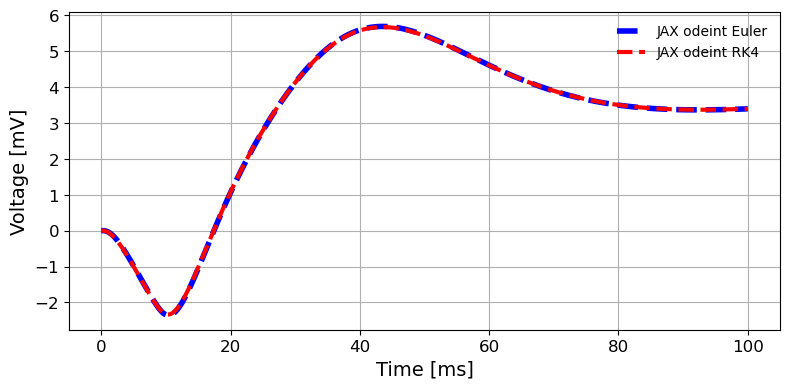

In [27]:
plt.figure(figsize=(8,4))
plt.plot(ts, xs_euler[:,8],'--', color='b', lw=4, label='JAX odeint Euler');
plt.plot(ts, xs_rk4[:,8],'--', color='r', lw=3, label='JAX odeint RK4');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout();
plt.show()

### Observation

In [28]:
eps_true = 0.005 #observation noise

In [29]:
params_true = np.append(theta_true, eps_true)
params_true

array([0.0045, 1.1   , 0.1   , 0.15  , 0.005 ])

In [30]:
xpy_jax = DCM_NMM_ERP_ODE_JAXOdeint(theta_true, constants, x_init, ts)

In [31]:
x_noise = np.random.normal(loc=0, scale=eps_true, size=xpy_jax.shape)

In [32]:
x_obs = xpy_jax + x_noise

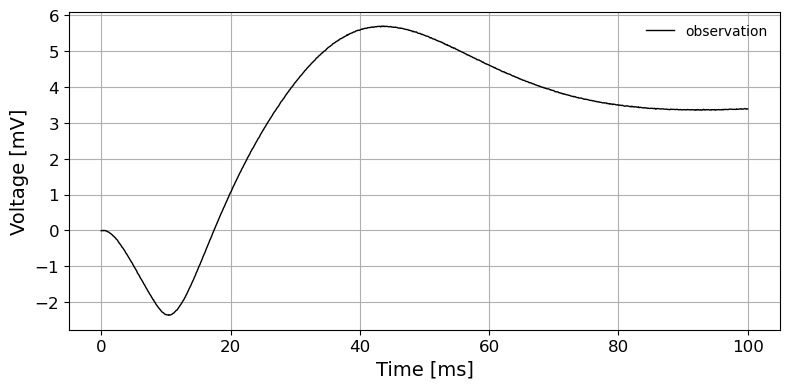

In [33]:
plt.figure(figsize=(8,4))
plt.plot(ts, x_obs,'-', color='k', lw=1, label='observation');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout();
plt.show()

In [34]:
#downsampling
ds_obs = 5
ds_sim = 5
nt=int(x_obs[::ds_sim].shape[0])
nt

201

In [35]:
params_labels=['$g_1$', '$g_2$', '$g_3$', '$g_4$']

In [36]:
prm_names = ['g_1', 'g_2', 'g_3', 'g_4']
num_params = len(prm_names)

In [37]:
def generate_data_dict(ds_obs, ds_sim, ts, dt, constants, x_init, x_obs):
    
    data_dict = {}
    
    data_dict['ds_obs'] = ds_obs
    data_dict['ds_sim'] = ds_sim
    data_dict['nt'] = int(x_obs[::ds_obs].shape[0])
    data_dict['ts'] = ts
    data_dict['dt'] = dt
    data_dict['constants'] = constants 
    data_dict['x_init'] = x_init
    data_dict['x_obs'] = x_obs[::ds_obs]

    return data_dict

In [38]:
model_data_dict = generate_data_dict(ds_obs, ds_sim, ts, dt, constants, x_init, x_obs)

## Prior

Gamma priors on parameters

In [ ]:
shape=[18.16, 7.0, 29.14, 30.77]
scale=[0.001, 0.15, 0.001, 0.01]

rate = 1 / np.array(scale)

In [40]:
prior_specs = dict(shape=shape, rate=rate)

In [41]:
def model(data_dict, prior_specs):
    #data_dict
    nt = data_dict['nt']
    dt = data_dict['dt']
    ts = data_dict['ts']
    ds_sim = data_dict['ds_sim']
    constants = data_dict['constants']
    x_init = data_dict['x_init']
    x_obs = data_dict['x_obs']

    # Priors                
    g1_samples = npyr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g2_samples = npyr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g3_samples = npyr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g4_samples = npyr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
        
    params_samples=[g1_samples, g2_samples, g3_samples, g4_samples]
    
    x_hat=DCM_NMM_ERP_ODE_JAXOdeint(params_samples, constants, x_init, ts)[::ds_sim]
    # Likelihood
    with plate('data', size=nt):
        x_hat = npyr.deterministic('x_hat', x_hat)
        npyr.sample('x_obs', dist.Normal(x_hat, 0.1), obs=x_obs)
        

draw from prior predictive

In [ ]:
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key, model_data_dict, prior_specs)

prior_theta_samples = np.array([prior_predictions[param] for param in prm_names]).T
prior_xhats = prior_predictions['x_hat']
prior_sample_array = xr.Dataset({'x_hat': (['sample', 'time'],  prior_xhats), 'parameter': (['sample', 'theta'], prior_theta_samples)}, coords={'theta': prm_names})
prior_sample_array.to_netcdf(parent_preprocess_dir + 'hmc_erp_GammaPrior_samples.nc')

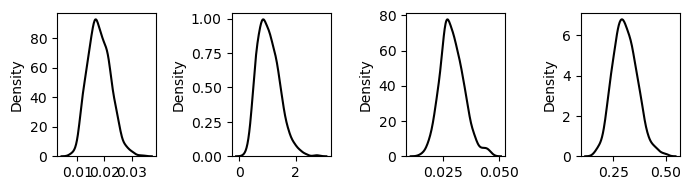

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(7, 2))
for iprm, prm in enumerate(prm_names):
    sns.kdeplot(prior_predictions[prm], color='k', ax=ax[iprm]);
fig.tight_layout()

In [44]:
n_ = 1000
params_prior_random = np.zeros((n_, 4))
keys_to_columns = {
    'g_1': 0,
    'g_2': 1,
    'g_3': 2,
    'g_4': 3,
}

for key, column in keys_to_columns.items():
    params_prior_random[:, column] = np.random.choice(prior_predictions[key], n_)

prior predictive checks

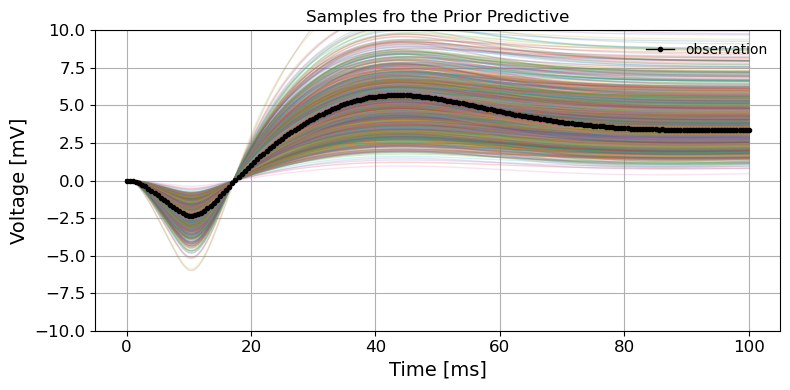

In [45]:
plt.figure(figsize=(8, 4))

for i in range(n_):
    plt.plot(ts[::ds_sim], prior_predictions['x_hat'][i], lw=1, alpha=0.2)
plt.plot(ts[::ds_sim], x_obs[::ds_sim] ,'.-', color='k', lw=1, label='observation');
plt.title('Samples fro the Prior Predictive')
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.ylim([-10, 10])
plt.tight_layout();
plt.show()

In [ ]:
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key, model_data_dict, prior_specs)

prior_theta_samples = np.array([prior_predictions[param] for param in prm_names]).T
prior_xhats = prior_predictions['x_hat']

prior_sample_array = xr.Dataset({'x_hat': (['sample', 'time'],  prior_xhats), 'parameter': (['sample', 'theta'], prior_theta_samples)}, coords={'theta': prm_names})
prior_sample_array.to_netcdf(parent_preprocess_dir + 'hmc_erp_GammaPrior_samples.nc')

# Preparing Empirical Data

In [42]:
def plot_all_ERPs(fig, ax, data, color='k', lw=1, alpha=0.5):

    # time_vec = np.linspace(-max_lead, max_lag, plotData.shape[0])
    time_vec = np.linspace(-max_lag, max_lead, data.shape[0])    

    ax.plot(time_vec, data.reshape(time_vec.shape[0], -1), c=color, lw=lw, alpha=alpha)

    ymin, ymax = data.min().round(1), data.max().round(1)
            
    ax.set_xticklabels(['-100', 'FB', '350'])
    ax.set_ylabel(r'Amplitude (mV)')
    ax.set_xlabel('Time (ms)')
    ax.set_aspect('auto', adjustable='box')
    fig.show()

## HMC sampling 

In [ ]:
task_ERPs = xr.load_dataarray(parent_preprocess_dir + 'normalized_task_ERPs_AllRegions.nc')

x_obs = task_ERPs.isel(electrode=0, condition=0).to_numpy()
model_data_dict = generate_data_dict(ds_obs, ds_sim, ts, dt, constants, x_init, x_obs)

num_conditions = len(task_ERPs.condition)
num_electrodes = len(task_ERPs.electrode)
num_timepoints = model_data_dict['nt']

max_lag = task_ERPs.attrs['MaxLag']
max_lead = task_ERPs.attrs['MaxLead']

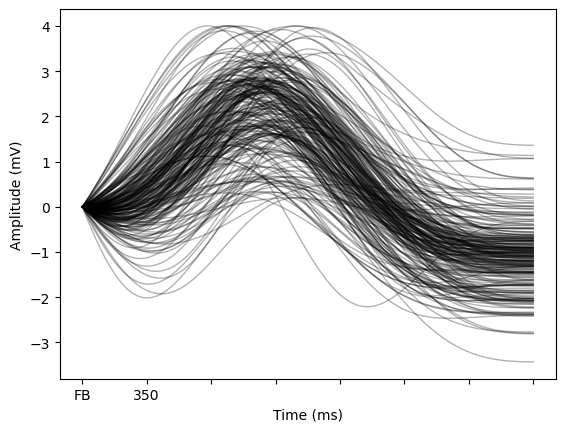

In [44]:
fig, ax = plt.subplots()
plot_all_ERPs(fig, ax, task_ERPs.to_numpy(), alpha=0.3,)

In [45]:
# NUTS set up
num_warmup, num_samples, num_chains = 2000, 1000, 4
kernel = NUTS(model, max_tree_depth=12, target_accept_prob=0.6, adapt_step_size=True, )
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, chain_method='parallel', progress_bar=False)

theta_dims = ('theta', 'chain', 'sample', 'electrode', 'condition')
xhat_dims = ('chain', 'sample', 'time', 'electrode', 'condition')

hmc_coords = dict(electrode=task_ERPs.electrode, condition=task_ERPs.condition, theta=prm_names)
xhat_coords = dict(electrode=task_ERPs.electrode, condition=task_ERPs.condition)

hmc_thetas = xr.DataArray(np.zeros((num_params, num_chains, num_samples, num_electrodes, num_conditions)),
                          dims=theta_dims, coords=hmc_coords)
hmc_xhats =  xr.DataArray(np.zeros((num_chains, num_samples, num_timepoints, num_electrodes, num_conditions)),
                          dims=xhat_dims, coords=xhat_coords)
hmc_lps = hmc_xhats.copy()

In [ ]:
for e_ind in trange(num_electrodes, desc='Electrode: ', leave=True):
    for c_ind in trange(num_conditions, desc='Condition: ', leave=False):

        x_obs = task_ERPs.isel(electrode=e_ind, condition=c_ind).to_numpy()
        model_data_dict = generate_data_dict(ds_obs, ds_sim, ts, dt, constants, x_init, x_obs)
        mcmc.run(rng_key, model_data_dict, prior_specs, extra_fields=('potential_energy',))
        pooled_results = az.from_numpyro(posterior=mcmc)

        hmc_thetas[:, :, :, e_ind, c_ind] = pooled_results['posterior'][prm_names].to_array().to_numpy()
        hmc_lps[:, :, :, e_ind, c_ind] = pooled_results['log_likelihood']['x_obs'].to_numpy()
        hmc_xhats[:, :, :, e_ind, c_ind] = pooled_results['posterior']['x_hat'].to_numpy()


hmc_thetas.to_netcdf(parent_preprocess_dir + 'erp_jax_thetas_all.nc')
hmc_xhats.to_netcdf(parent_preprocess_dir + 'erp_jax_xhats_all.nc')
hmc_lps.to_netcdf(parent_preprocess_dir + 'erp_jax_lps_all.nc')
mean_lps = hmc_lps.mean('time').copy()

## Outputs

In [52]:
hmc_thetas = xr.load_dataarray(parent_preprocess_dir + 'erp_jax_thetas_all.nc')
hmc_xhats = xr.load_dataarray(parent_preprocess_dir + 'erp_jax_xhats_all.nc')
hmc_lps = xr.load_dataarray(parent_preprocess_dir + 'erp_jax_lps_all.nc')
mean_lps = hmc_lps.mean('time').copy()

In [54]:
maxLPs = mean_lps.max('sample')
minLPs = mean_lps.min('sample')
condMaxLPs = maxLPs.max('chain')
avgLPs = mean_lps.mean('sample')

condAvgLPs = mean_lps.mean('sample').mean('chain')
rangeLPs = (maxLPs - minLPs).mean('chain')

nan_lps = avgLPs == avgLPs
threshLPs = condMaxLPs - (rangeLPs*1)

fitChains_hmc = ((avgLPs >= threshLPs) & (nan_lps)).to_numpy()

In [55]:
aggTheta = hmc_thetas.transpose('theta', 'sample', 'chain', 'electrode', 'condition').where(fitChains_hmc)
aggTheta = aggTheta.stack(aggSample=('chain','sample'))

aggXhat = hmc_xhats.transpose('time', 'sample', 'chain', 'electrode', 'condition').where(fitChains_hmc)
aggXhat = aggXhat.stack(aggSample=('chain','sample'))

In [56]:
df = hmc_thetas.transpose('theta', 'sample', 'chain', 'electrode', 'condition').where(fitChains_hmc).stack(aggSample=('theta', 'sample', 'chain',  'electrode', 'condition'))
df = df.to_dataframe(name = 'value')
dfInds = df.index
df.index = np.arange(len(dfInds))

In [57]:
palette = {'Presence': 'dodgerblue', 'Absence': 'crimson'}

bw = 0.3
width_viol = 0.5
orient = 'v'
alpha = .99
dodge = True
pointplot = False
move = 0.2
point_size = 0
cut = 0.5
scale = 'area'
width_box = 0.5
line_width = 0.1
saturation = 1

In [58]:
# (Replace with your Wasserstein distance calculation function)
def wasserstein_distance(sample1, sample2, n_permutations=100):

    combined_data = np.concatenate([sample1, sample2])
    observed_distance = stats.wasserstein_distance(sample1, sample2)
    
    # Number of permutations
    p_value = 0
    for _ in range(n_permutations):
      # Shuffle data points within combined sample
      shuffled_data = np.random.permutation(combined_data)
      shuffled_sample1 = shuffled_data[:len(sample1)]
      shuffled_sample2 = shuffled_data[len(sample1):]
      
      # Calculate distance for shuffled samples
      shuffled_distance = stats.wasserstein_distance(shuffled_sample1, shuffled_sample2)
      
      # Update p-value if shuffled distance is greater than observed
      if shuffled_distance >= observed_distance:
        p_value += 1
    
    p_value /= n_permutations

    return (observed_distance, p_value)

In [ ]:
stats_tests = [stats.ks_2samp, wasserstein_distance, stats.mannwhitneyu]

erp_con_stats = xr.DataArray(np.zeros((len(stats_tests), 2, num_params)), dims=('method', 'stat', 'theta'),
                             coords=dict(method=['KS', 'Wasserstein', 'MWU'], stat=['value', 'pvalue'], theta=hmc_thetas.coords['theta'].to_numpy()))

for p_ind, param in enumerate(hmc_thetas.theta.to_numpy()):

    param_df = df[df.theta == param].copy().dropna()
    p_thetas = param_df[param_df['condition'] == 'Presence'].value.to_numpy()
    a_thetas = param_df[param_df['condition'] == 'Absence'].value

    for st_ind, current_test in enumerate(stats_tests):
    
        test_results = current_test(p_thetas, a_thetas)
        erp_con_stats[st_ind, :, p_ind] = np.array([test_results[0], test_results[1]])

erp_con_stats.to_netcdf(parent_preprocess_dir + 'erp_con_stats.nc')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_2_Presence vs. g_2_Absence: KS: 0.2, ****
g_1_Presence vs. g_1_Absence: KS: 0.03, ****
g_3_Presence vs. g_3_Absence: KS: 0.04, ****
g_4_Presence vs. g_4_Absence: KS: 0.04, ****


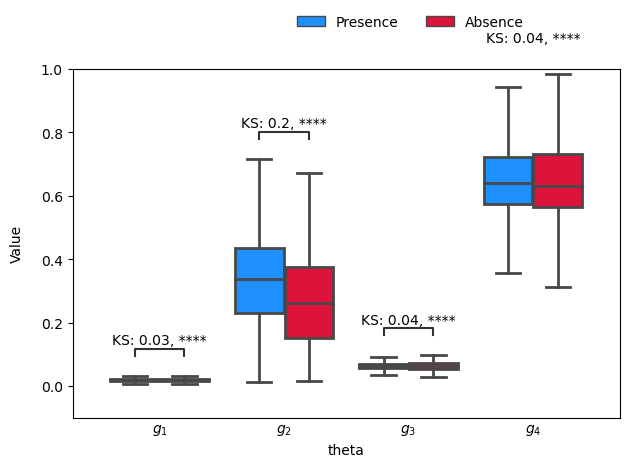

In [ ]:
f2, ax2 = plt.subplots()

labels = [r'$g_1$', r'$g_2$', r'$g_3$', r'$g_4$']
sig_pairs = [(('g_1','Presence'), ('g_1','Absence')),
             (('g_2','Presence'), ('g_2','Absence')),
             (('g_3','Presence'), ('g_3','Absence')),
             (('g_4','Presence'), ('g_4','Absence'))]


boxs = sns.boxplot(x="theta", y="value", data=df, palette=palette, showfliers=False,
               hue='condition', saturation = saturation, dodge=True, ax=ax2, linewidth = 2) 


ks_tests = erp_con_stats.isel(method=0).to_numpy()
custom_annotations = ['KS: ' + str(ks_tests[0, p_ind].round(2)) + ', ' + pval_to_string([ks_tests[1, p_ind]])[0] for p_ind in range(4)]

annotator = Annotator(x = 'theta', y = 'value', hue='condition', pairs = sig_pairs, data=df, ax=boxs)
annotator.set_custom_annotations(custom_annotations)
annotator.annotate()

ax2.set_ylim([-0.1, 1])
ax2.set_xticklabels(labels)
ax2.tick_params(axis='both', which='major')
ax2.tick_params(axis = 'x', length = 0)
ax2.legend(ncol = 2, loc = (0.4, 1.1), frameon= False)
ax2.set_ylabel('Value', labelpad = 12)
f2.tight_layout()

In [ ]:
chain_ind = 0
tend = 1000
_, num_timepoints, _, _ = erp_default_config(tend=tend)
concat_elecs = hmc_thetas.electrode

erp_trajectories = xr.DataArray(np.zeros((3, num_timepoints, len(concat_elecs), 2)), dims=('subpopulation', 'time', 'electrode', 'condition'),
                                coords=dict(subpopulation=['SC', 'IN', 'PN'], condition=['Presence', 'Absence']))

for e_ind in range(len(concat_elecs)):
    
    elec_thetas = hmc_thetas.isel(chain=chain_ind, electrode=e_ind).copy().T

    for c_ind in range(2):
        condition_thetas = posterior_peaks(elec_thetas.isel(condition=c_ind).to_numpy())

        xsc, xin, xpy = simulate_from_posterior(condition_thetas, tend=tend) 
        
        erp_trajectories[0, :, e_ind, c_ind] = xsc
        erp_trajectories[1, :, e_ind, c_ind] = xin
        erp_trajectories[2, :, e_ind, c_ind] = xpy
        
erp_trajectories.to_netcdf(parent_preprocess_dir + '/erp_trajectories.nc')